In [2]:
## Import base libraries ##
import numpy as np
import math
from scipy import stats
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import pandas as pd
import GPy

In [3]:
## List of functions for GPR ##
## ============================ ##
from GPy.core.parameterization.priors import Prior
import weakref
class KDEPrior(Prior):
    _instances = []

    def __new__(cls, samples):  # Singleton:
#         if cls._instances:
#             cls._instances[:] = [instance for instance in cls._instances if instance()]
#             for instance in cls._instances:
#                 if instance().samples == samples:
#                     return instance()
        newfunc = super(Prior, cls).__new__
        if newfunc is object.__new__:
            o = newfunc(cls)
        else:
            o = newfunc(cls, samples)
        cls._instances.append(weakref.ref(o))
        return cls._instances[-1]()

    def __init__(self, samples):
        self.samples = samples
        self.kde = gaussian_kde(self.samples)

    def __str__(self):
        return "KDE"

    def lnpdf(self, x):
        return np.log(self.kde.pdf(x))

    def lnpdf_grad(self, x):
        # Approximate the gradient by calculating the difference in the log PDF at two close points
        epsilon = 1e-8
        log_pdf_grad = (np.log(self.kde.pdf(x + epsilon)) - np.log(self.kde.pdf(x - epsilon))) / (2 * epsilon)
        return log_pdf_grad

    def rvs(self, n=None):
        # Generate random samples from the KDE-based prior
        return self.kde.resample(size=n).flatten()


#Xtest that returns largest predictive std is
def find_Xtest(m, X, y, dim):
    #Create test data
    N = len(X) #in one dim
    n = 20 #in one dim
    step = np.abs(np.max(X) - np.min(X))/n # step size for Xtest
    
    r = []
    for i in range(dim):
        rx_i = np.arange(np.min(X), np.max(X), step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest_og = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest_og.shape = (n x dim)

    
    mu, std = m.predict_noiseless(Xnew = Xtest_og, full_cov = False)
    mu = mu[:,0]
    std = np.sqrt(np.abs(std))[:,0]
    Xtest_maxstd = Xtest_og[np.argmax(std)].reshape(-1,dim)
    return Xtest_maxstd    


def multistart(m, n_starts = 50, optimizer = "lbfgs", noise = 0.00001, fixed_noise = True):
    '''
    Optimizer methods: 'scg','lbfgs','org-bfgs','fmin_tnc','adam'
    '''
    #Number of optimization starts
    best_model = None
    best_log_likelihood = -np.inf
    
    ## Perform multistart optimization
    for i in range(n_starts):
        # Randomly initialize the kernel parameters
        m.randomize()
        
        # Optimize the model
        m.optimize(optimizer = optimizer)
        
        # Keep track of the best model based on log likelihood
        if m.log_likelihood() > best_log_likelihood:
            best_log_likelihood = m.log_likelihood()
            best_model = m.copy()  # Store the best model

        print("Multistart iteration = ",i,end="\r")
    m = best_model
    return m


#global error:
def global_error(m, minX, maxX, dim, f, n = 200, multiout = False, outputdim = 0):
    #Create test data
    step = np.abs(maxX - minX)/n # step size for Xtest
    
    r = []
    for i in range(dim):
        rx_i = np.arange(minX, maxX, step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest.shape = (n x dim)

    ytest = f(Xtest).reshape(-1,1) #observations (following true unknown function we wish to approx)
    
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    if multiout == True:
        if outputdim == 0:
            task_index = np.zeros((Xtest.shape[0], 1))
        if outputdim == 1:
            task_index = np.ones((Xtest.shape[0], 1))
        Xtest_with_index = np.hstack([Xtest, task_index])
        mu, std = m.predict_noiseless(Xnew =  Xtest_with_index, full_cov = False)
    else:
        mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)


    #Normalized RMSE
    rmse = np.sqrt(np.mean((mu-ytest)**2))/np.std(ytest)
    return rmse
    

#local error (max error)
def local_error(m, minX, maxX, dim, f, n = 200, multiout = False, outputdim = 0):
    #Create test data
    step = np.abs(maxX - minX)/n # step size for Xtest
    
    r = []
    for i in range(dim):
        rx_i = np.arange(minX, maxX, step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest.shape = (n x dim)

    ytest = f(Xtest).reshape(-1,1) #observations (following true unknown function we wish to approx)
    
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    if multiout == True:
        if outputdim == 0:
            task_index = np.zeros((Xtest.shape[0], 1))
        if outputdim == 1:
            task_index = np.ones((Xtest.shape[0], 1))
        Xtest_with_index = np.hstack([Xtest, task_index])
        mu, std = m.predict_noiseless(Xnew =  Xtest_with_index, full_cov = False)
    else:
        mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)

    maxerror = np.max(np.abs(mu-ytest))/np.std(ytest)
    return maxerror


## List of functions for 1D GPR ##
## ============================ ##
#generate points that aren't too close to each other
def generate_points(minX, maxX, N, min_distance = 0.05, dim = 1):
    if min_distance == 0.05:
        min_distance = np.abs(maxX-minX)/(2*N)
        print(min_distance)
    points = []
    while len(points) < N:
        # Generate a random point
        point = np.random.uniform(-5, 5, size=(2,dim)) # Adjust range as needed
        if len(points) == 0:
            points.append(point)
        else:
            # Check distance with existing points
            valid_point = True
            for existing_point in points:
                distance = np.linalg.norm(point - existing_point)
                if distance < min_distance:
                    valid_point = False
                    break
            if valid_point:
                points.append(point)
    #print(np.concatenate(points))
    return np.concatenate(points)


#Lengthscale initial guess
def wavelength(X,y):
    '''
    python write a function that iteratively increases the neighborhood size on the x axis
    around the global maximum of y until it finds the smallest y value in a neighborhood
    where the y values are decreasing just before they begin increasing. return the distance
    along the x axis between the global maximum of y and that smallest y value
    '''
    ymax = np.max(y)
    ymax_i = np.argmax(y)
    ymax_x = X[ymax_i]

    loweri = 0
    upperi= len(y)-1

    ysmall_right = ymax
    ysmall_right_i = ymax_i
    i = ymax_i + 1
    while i <= upperi:    
        if y[i-1] >= y[i]: #if left y > right y
            ysmall_right = y[i]
            ysmall_right_i = i
            i = i+1
        else:
            break

    ysmall_left = ymax
    ysmall_left_i = ymax_i
    i = ymax_i - 1    
    while i >= loweri:
        if y[i] <= y[i+1]: #if left y < right y
            ysmall_left = y[i]
            ysmall_left_i = i
            i = i-1
        else:
            break
            
    if ysmall_right<ysmall_left:
        ysmall = ysmall_right
        ysmall_i = ysmall_right_i
    else:
        ysmall = ysmall_left
        ysmall_i = ysmall_left_i
    #print(ysmall)
    ysmall_x = X[ysmall_i]
    #print(ysmall_x)
    wavelength = np.abs(ymax_x - ysmall_x)
    #print(wavelength)
    return wavelength[0]


def rbf_init_par(X,y):
    init_sigma_n = 0#0.0001 #np.std(y) # guess for observation noise
    init_len_scale = wavelength(X,y)
    init_sigma_f = np.abs(np.max(y) - np.min(y)) #this is the range of the observations
    init_par = [init_sigma_n, init_len_scale, init_sigma_f]
    return init_par
    

#plot the posterior distribution of GPR (GPy version)
def GPy_plot_post(m, X, minX, maxX, y, f, n = 200):
    '''
    Plot the posterior distribution of GPR
    '''
    Xtest = np.linspace(minX, maxX, n).reshape(-1,1)
    
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)
    mu = mu[:,0]
    std = np.sqrt(np.abs(std))[:,0]
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(8,4))

    # Plot training data
    plt.plot(X, y, 'kx', ms=9)
    # Plot test points
    plt.plot(Xtest, f(Xtest), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, '-', lw=2, color = "#3465a4")
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest[:,0], mu-2*std, mu+2*std, color="#e2ebf5")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()
    
    
## List of functions for 2D GPR ##
## ============================ ##
def GPy_plot_2D(m, X, y, multiout = False, outputdim = 0):
    dim = 2
    
    #Create test data
    n = 20 #in one dim
    step = np.abs(np.max(X) - np.min(X))/n # step size for Xtest
    
    r = []
    for i in range(dim):
        rx_i = np.arange(np.min(X), np.max(X), step)
        r.append(rx_i)
    r = np.array(r)
    g = np.array(np.meshgrid(*r))
    g_ravel = []
    for i in range(len(g)):
        g_ravel.append(g[i].ravel())
    g_ravel = np.array(g_ravel)
    Xtest = np.c_[g_ravel.T] #np.c_ : [[x1,x2,etc.],[y1,y2,etc.]] --> [[x1,y1],[x2,y2],etc.]
    #Xtest.shape = (n x dim)
    
    #full_cov = False -> std (diag of Cov). Otherwise Cov
    if multiout == True:
        if outputdim == 0:
            task_index = np.zeros((Xtest.shape[0], 1))
        if outputdim == 1:
            task_index = np.ones((Xtest.shape[0], 1))
        Xtest_with_index = np.hstack([Xtest, task_index])
        mu, std = m.predict_noiseless(Xnew =  Xtest_with_index, full_cov = False)
    else:
        mu, std = m.predict_noiseless(Xnew = Xtest, full_cov = False)
    
    ##Render plots
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    # Plot predictive mean
    gx1, gx2 = g[0], g[1]
    
    #Render plots
    surf = ax.plot_surface(gx1, gx2, mu.reshape(gx1.shape), cmap=cm.coolwarm,
                           linewidth=0, antialiased=False, alpha = 0.3)
    
    #Plot training data
    ax.scatter(X[:,0], X[:,1], y, c = y, marker = 'o', cmap=cm.coolwarm)
    
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

## 2D Multi-output problem
https://arxiv.org/pdf/2203.06334

Pearson correlation coefficient
[[ 1.         -0.06664089]
 [-0.06664089  1.        ]]


Text(0.5, 0.5, 'X22')

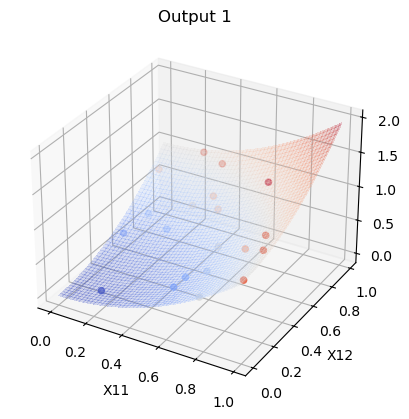

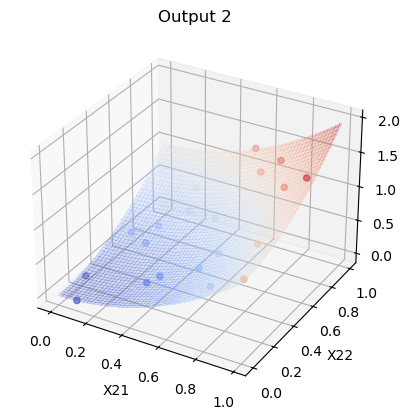

In [4]:
from pyDOE import lhs

#These functions generate data corresponding to two outputs
f1 = lambda x: (x[:,0])**2 + x[:,1]**2
f2 = lambda x: f1(x)

#{X,Y} training set for each output. num_samplesxD array
num_samples = 20
D = 2 #dimension
xmin = 0
xmax = 1
#lhs returns samples between [0,1]
X1 = (xmax-xmin)*lhs(D, samples=num_samples, criterion='m')+xmin;
X2 = (xmax-xmin)*lhs(D, samples=num_samples, criterion='m')+xmin;
Y1 = f1(X1).reshape(-1,1) #+ np.random.normal(0, 0.25, num_samples).reshape(-1,1)
Y2 = f2(X2).reshape(-1,1) #+ np.random.normal(0, 0.16, num_samples).reshape(-1,1)

print("Pearson correlation coefficient")
print(np.corrcoef(Y1.T,Y2.T))


## 2D implementation only: ##
## ======================= ##
#X1 data for plotting
num_ratio = 0.01
X11 = X1[:,0]
X12 = X1[:,1]
f1_2d = lambda x, y: f1(np.c_[x.ravel(), y.ravel()]).reshape(x.shape)
#X mesh grid for plotting purposes
rx11, rx12 = np.arange(xmin, xmax, num_ratio), np.arange(xmin, xmax, num_ratio)
gx11, gx12 = np.meshgrid(rx11, rx12)
x = np.c_[gx11.ravel(), gx12.ravel()]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(gx11, gx12, f1_2d(gx11,gx12), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha = 0.2)
ax.scatter(X11, X12, Y1, c = Y1, marker = 'o', cmap=cm.coolwarm)
ax.set_title("Output 1")
ax.set_xlabel('X11')
ax.set_ylabel('X12')


#X2 data for plotting
X21 = X2[:,0]
X22 = X2[:,1]
f2_2d = lambda x, y: f2(np.c_[x.ravel(), y.ravel()]).reshape(x.shape)
#X mesh grid for plotting purposes
rx21, rx22 = np.arange(xmin, xmax, num_ratio), np.arange(xmin, xmax, num_ratio)
gx21, gx22 = np.meshgrid(rx21, rx22)
x = np.c_[gx21.ravel(), gx22.ravel()]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(gx21, gx22, f2_2d(gx21,gx22), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha = 0.2)
ax.scatter(X21, X22, Y2, c = Y2, marker = 'o', cmap=cm.coolwarm)
ax.set_title("Output 2")
ax.set_xlabel('X21')
ax.set_ylabel('X22')

---
## 1-D Multiple response GP

### Intro
Say we want to infer multiple outputs which have the same source of uncertainty from the inputs, like in the example above. We may certainly perform two individual GPs, one for output 1 and the other for output 2, we could have a more informative model if we considered the covariance between the two outputs.
<br><br>
So, if we were to only consider the two models individually, we have

$$f_1(x)\sim GP(0,K_1(x,x'))$$

$$f_2(x)\sim GP(0,K_2(x,x'))$$

$$y(x_{i,1}) = f_1(x_{i,1})+\epsilon_i$$

$$y(x_{i,1}) = f_2(x_{i,2})+\epsilon_i$$

$$\epsilon_i\sim N(0,\sigma^2)$$

Our observed data is $D_1 = \{(x_{i,1},y(x_{i,1}))\vert i=1,\ldots,N\}$ and $D_2 = \{(x_{i,2},y(x_{i,2}))\vert i=1,\ldots,N\}$. Then for each GP we have

$$
[y(x_{1,1})\ldots y(x_{N,1})]^T\sim N(0,K_1+\sigma_1^2I)
$$

$$
[y(x_{1,2})\ldots y(x_{N,2})]^T\sim N(0,K_2+\sigma_2^2I)
$$

where

$$
K_1=[[k(x_{1,1},x_{1,1})\ldots k(x_{N,1},x_{1,1})]^T \ldots [k(x_{1,1},x_{N,1})\ldots k(x_{N,1},x_{N,1})]^T]
$$

$$
K_2=[[k(x_{1,2},x_{1,2})\ldots k(x_{N,2},x_{1,2})]^T \ldots [k(x_{1,2},x_{N,2})\ldots k(x_{N,2},x_{N,2})]^T]
$$

<br><br>

We can combine these individual GPs as one model:

$$
[y_1,y_2]^T \sim N([0,0]^T, [[K_1,0]^T [0,K_2]^T] + [[\sigma_1^2I,0]^T [0,\sigma_2^2I]^T])
$$

$$
y\sim N(0,K_{f,f}+\Sigma)
$$

Rather than having $K_{f,f} = [[K_1,0]^T [0,K_2]^T]$, we want to find diagonal terms to take into consideration interaction between one output model and the other. There are two approaches we can take: 1) intrisic coregionalization model (ICM) or 2) linear model of coregionalization (LMC). 

---

### ICM
ICM considers $d=1,\ldots,R$ (example: $R=2$) multi-output models with only one latent covariance $K$.

$$f_d(x)\sim GP(0,K(x,x'))$$

Individually, we have the following $R$ outputs $f_d(x)$ defined above which input the same feature space $x$. Taking a sample from a GP of that kernel, $u^j(x)\sim GP(0,K(x,x'))$, we assume the linear transformations

$$
f_d(x)=\sum_{j=1}^P a_d^ju^j(x)
$$

where $d = 1,\ldots,R$, $j=1,\ldots P\leq R$, and

$$
a^j = [a_1^j,\ldots, a_R^j]^T
$$

is a $R$x$1$ vector. We further define the $R$x$1$ vector

$$
f(x) = [f_1(x),\ldots,f_R(x)]^T
$$

$$
A = [a^1 \ldots a^P]
$$

, a $R$x$P$ matrix,

$$
B = AA^T
$$

where the rank of this $R$x$R$ matrix $B$ is $P$. Then,

$$
K_{ICM} = cov(f(x),f(x')) = AA^T K(x,x') = B K(x,x')
$$

Note that we write $B = WW^T+diag(\kappa)$ to ensure $B$ is positive definite.

---

### LMC
The ICM is a special case of the LMC with one input kernel $K$. If we have two or more input kernels $K_1,K_2,\ldots$, the LMC model is the sum of individual ICM models.

$$
K_{LMC} = B_1K_{ICM_1} + B_2K_{ICM_2} + \cdots
$$


---
#### Individaul GPs

 C:\Users\Sasha\anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:divide by zero encountered in log
 C:\Users\Sasha\anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                    28.08994143  |      +ve      |        
  [1]    |                    28.27090566  |      +ve      |        
  index  |  GP_regression.rbf.variance  |  constraints  |  priors
  [0]    |             251337.13850081  |      +ve      |        
  index  |  GP_regression.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                             0.00000000  |   +ve fixed   |        

Log-likelihood =  89.20356644311781
RMSE =  4.169737799630337e-05
Max error =  0.0003402368072622613


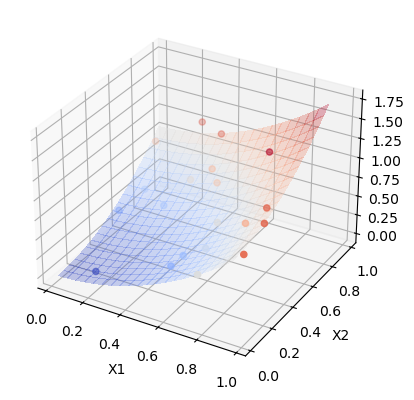

In [5]:
#Define kernel
K = GPy.kern.RBF(input_dim=D, variance=1, lengthscale=[10,10], ARD = True)

#Define GPR
model1 = GPy.models.GPRegression(X1,Y1,K)

#Optimize
model1.Gaussian_noise.variance = 0
model1.Gaussian_noise.variance.fix()
model1 = multistart(model1, n_starts = 5, optimizer = "lbfgs")

print(model1.rbf.lengthscale)
print(model1.rbf.variance)
print(model1.Gaussian_noise.variance)
print("")
print("Log-likelihood = ", model1.log_likelihood())
print("RMSE = ", global_error(model1, xmin, xmax, D, f1, n = 30, multiout = False, outputdim = 0))
print("Max error = ", local_error(model1, xmin, xmax, D, f1, n = 30, multiout = False, outputdim = 0))

GPy_plot_2D(model1, X1, Y1)

 C:\Users\Sasha\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 C:\Users\Sasha\anaconda3\lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                    28.21700677  |      +ve      |        
  [1]    |                    28.20136354  |      +ve      |        
  index  |  GP_regression.rbf.variance  |  constraints  |  priors
  [0]    |             251921.11495300  |      +ve      |        
  index  |  GP_regression.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                             0.00000000  |   +ve fixed   |        

Log-likelihood =  88.50782351924202
RMSE =  3.8657680995437395e-05
Max error =  0.0003154732601444418


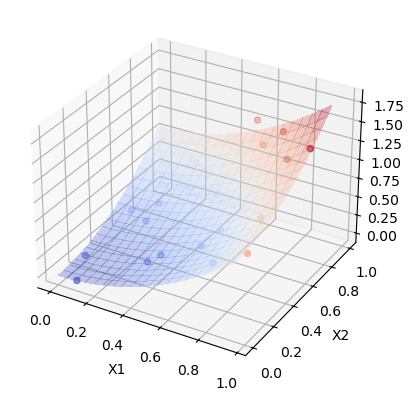

In [6]:
#Define kernel
K = GPy.kern.RBF(input_dim=D, variance=1, lengthscale=[10,10], ARD = True)

#Define GPR
model2 = GPy.models.GPRegression(X2,Y2,K)

#Optimize
model2.Gaussian_noise.variance = 0
model2.Gaussian_noise.variance.fix()
model2 = multistart(model2, n_starts = 50, optimizer = "lbfgs")

print(model2.rbf.lengthscale)
print(model2.rbf.variance)
print(model2.Gaussian_noise.variance)
print("")
print("Log-likelihood = ", model2.log_likelihood())
print("RMSE = ", global_error(model2, xmin, xmax, D, f1, n = 30, multiout = False, outputdim = 0))
print("Max error = ", local_error(model2, xmin, xmax, D, f1, n = 30, multiout = False, outputdim = 0))

GPy_plot_2D(model2, X2, Y2)

In [7]:
#Define B matrix
B = GPy.kern.Coregionalize(input_dim = D, output_dim = 2) #two outputs
multkernel = K.prod(B,name='B.K')
print(multkernel)

  B_K.             |               value  |  constraints  |  priors
  rbf.variance     |  135726.75186906106  |      +ve      |        
  rbf.lengthscale  |                (2,)  |      +ve      |        
  coregion.W       |              (2, 1)  |               |        
  coregion.kappa   |                (2,)  |      +ve      |        


In [8]:
#Components of B
print('W matrix\n',B.W)
print('\nkappa vector\n',B.kappa)
print('\nB matrix\n',B.B)

W matrix
   index  |   coregion.W  |  constraints  |  priors
  [0 0]  |  -0.43215691  |               |        
  [1 0]  |  -1.10254159  |               |        

kappa vector
   index  |  coregion.kappa  |  constraints  |  priors
  [0]    |      0.50000000  |      +ve      |        
  [1]    |      0.50000000  |      +ve      |        

B matrix
 [[0.68675959 0.47647097]
 [0.47647097 1.71559796]]


In [9]:
print(B.W*B.W.T + 0.5*np.eye(2,2))

[[0.68675959 0.47647097]
 [0.47647097 1.71559796]]


In [16]:
np.linalg.matrix_rank(B.W) #get rank of W matrix (A matrix in notes)

1

In [15]:
P = 1
icm = GPy.util.multioutput.ICM(input_dim = D, num_outputs=2, kernel=K, W_rank = P)
print(icm)

  ICM.             |               value  |  constraints  |  priors
  rbf.variance     |  135726.75186906106  |      +ve      |        
  rbf.lengthscale  |                (2,)  |      +ve      |        
  B.W              |              (2, 1)  |               |        
  B.kappa          |                (2,)  |      +ve      |        


#### Combined Model

  index  |  gp.ICM.rbf.lengthscale  |  constraints  |  priors
  [0]    |             51.70909572  |      +ve      |        
  [1]    |             51.29528901  |      +ve      |        
  index  |                       gp.ICM.rbf.variance  |  constraints  |  priors
  [0]    |                               76.80191929  |      +ve      |        
  -----  |  gp.mixed_noise.Gaussian_noise_0.variance  |  -----------  |  ------
  [0]    |                                0.00000000  |   +ve fixed   |        
  -----  |  gp.mixed_noise.Gaussian_noise_1.variance  |  -----------  |  ------
  [0]    |                                0.00000000  |   +ve fixed   |        
  index  |  gp.mixed_noise.Gaussian_noise_0.variance  |  constraints  |  priors
  [0]    |                                0.00000000  |   +ve fixed   |        
  -----  |  gp.mixed_noise.Gaussian_noise_1.variance  |  -----------  |  ------
  [0]    |                                0.00000000  |   +ve fixed   |        

Log-likelihoo

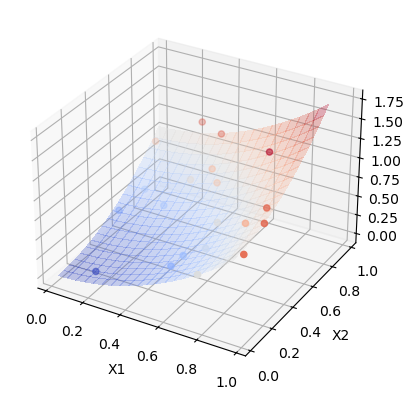

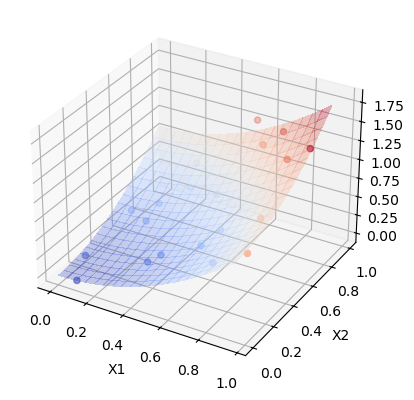

In [17]:
#Define GPR
m = GPy.models.GPCoregionalizedRegression([X1,X2], [Y1,Y2], kernel = icm)

#Constrain parameters
m['.*noise'] = 0
m['.*noise'].fix()

#Optimize
m = multistart(m, n_starts = 50, optimizer = "lbfgs")

#Results
print(m['.*lengthscale'])
print(m['.*variance'])
print(m['.*noise'])
print("")
print("Log-likelihood = ", m.log_likelihood())
print("\n OUTPUT 1")
print("RMSE = ", global_error(m, xmin, xmax, D, f1, n = 20, multiout = True, outputdim = 0))
print("Max error = ", local_error(m, xmin, xmax, D, f1, n = 20, multiout = True, outputdim = 0))
print("\n OUTPUT 2")
print("RMSE = ", global_error(m, xmin, xmax, D, f2, n = 20, multiout = True, outputdim = 1))
print("Max error = ", local_error(m, xmin, xmax, D, f2, n = 20, multiout = True, outputdim = 1))

GPy_plot_2D(m, X1, Y1, multiout = True, outputdim = 0)
GPy_plot_2D(m, X2, Y2, multiout = True, outputdim = 1)

In [20]:
#Components of B
print('W matrix\n',icm.B.W)
print('\nkappa vector\n',icm.B.kappa)
print('\nB matrix\n',icm.B.B)
print('')
print('Rank of W matrix:',np.linalg.matrix_rank(B.W)) #get rank of B matrix

W matrix
   index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -41.76956051  |               |        
  [1 0]  |  -41.76985422  |               |        

kappa vector
   index  |  gp.ICM.B.kappa  |  constraints  |  priors
  [0]    |      0.00000000  |      +ve      |        
  [1]    |      0.00000000  |      +ve      |        

B matrix
 [[1744.69618494 1744.70845313]
 [1744.70845313 1744.7207214 ]]

Rank of W matrix: 1
